# Estrategias de Exploración vs Explotación en Gymnasium (`Boxing-v5`)

Este notebook aplica cuatro estrategias de balance entre exploración y explotación usando aprendizaje por refuerzo en el entorno de Atari `Boxing-v5`.

Las estrategias implementadas son:

1. **Epsilon-Greedy**
2. **Valores Iniciales Optimistas**
3. **Softmax**
4. **Upper Confidence Bound (UCB)**

Cada técnica se entrena durante 100 episodios y se evalúa individualmente, seguida de una comparación visual y una ejecución final del entorno con la mejor política aprendida.


In [9]:
import gymnasium as gym
import ale_py
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
from math import log, exp


In [10]:
def discretizar(observation):
    """Reduce la observación de imagen (210x160) a una matriz hashable (5x5)."""
    resized = cv2.resize(observation, (5, 5))
    discretized = (resized / 255 * 5).astype(np.int32)
    return tuple(discretized.flatten())


In [11]:
def train(policy_fn, episodes=100, init_q=0, render=False):
    env = gym.make("ALE/Boxing-v5", render_mode="human" if render else "rgb_array", obs_type="grayscale")
    q_table = defaultdict(lambda: np.full(env.action_space.n, init_q, dtype=np.float32))
    action_counts = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = np.zeros(episodes)
    epsilon = 1
    epsilon_decay = 0.01

    for i in range(episodes):
        state = discretizar(env.reset()[0])
        terminated = False
        truncated = False
        total_reward = 0

        while not terminated and not truncated:
            action = policy_fn(q_table, action_counts, state, i, epsilon)
            new_state, reward, terminated, truncated, _ = env.step(action)
            new_state = discretizar(new_state)

            # Actualización Q-learning
            old_value = q_table[state][action]
            next_max = np.max(q_table[new_state])
            q_table[state][action] += 0.3 * (reward + 0.95 * next_max - old_value)
            action_counts[state][action] += 1

            state = new_state
            total_reward += reward

        rewards_per_episode[i] = total_reward
        epsilon = max(epsilon - epsilon_decay, 0)

    env.close()
    return rewards_per_episode, q_table


## 1. Epsilon-Greedy

Esta estrategia elige una acción aleatoria con probabilidad ε (exploración) y la mejor acción conocida con probabilidad 1−ε (explotación).


In [12]:
def epsilon_greedy(q_table, action_counts, state, t, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_table[state]))
    return np.argmax(q_table[state])


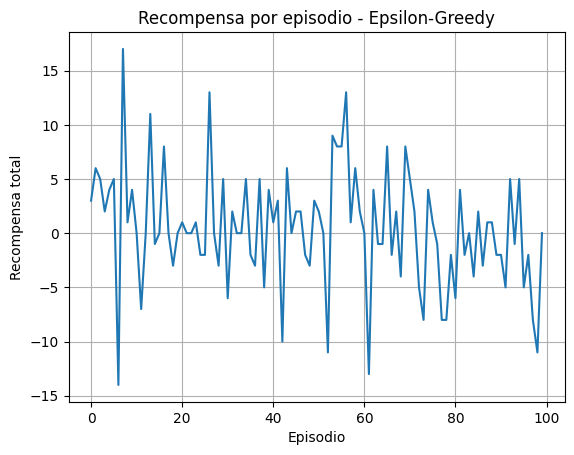

In [13]:
rewards_eps, _ = train(epsilon_greedy, episodes=100)
plt.plot(rewards_eps)
plt.title("Recompensa por episodio - Epsilon-Greedy")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.grid(True)
plt.show()


## 2. Valores Iniciales Optimistas

Consiste en inicializar los valores Q con estimaciones muy altas para forzar al agente a explorar todas las acciones al inicio.


In [14]:
def optimista(q_table, action_counts, state, t, epsilon):
    return np.argmax(q_table[state])


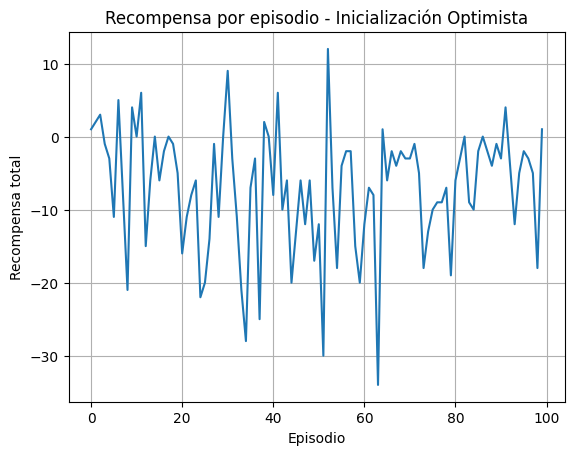

In [15]:
rewards_opt, _ = train(optimista, episodes=100, init_q=5)
plt.plot(rewards_opt)
plt.title("Recompensa por episodio - Inicialización Optimista")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.grid(True)
plt.show()


## 3. Softmax

Esta técnica convierte los valores Q en probabilidades usando una función exponencial. Así, las acciones con mayor Q tienen más probabilidad, pero no excluye otras.


In [16]:
def softmax(q_table, action_counts, state, t, epsilon):
    q_values = q_table[state]
    exp_q = np.exp(q_values - np.max(q_values))
    probs = exp_q / np.sum(exp_q)
    return np.random.choice(len(q_values), p=probs)


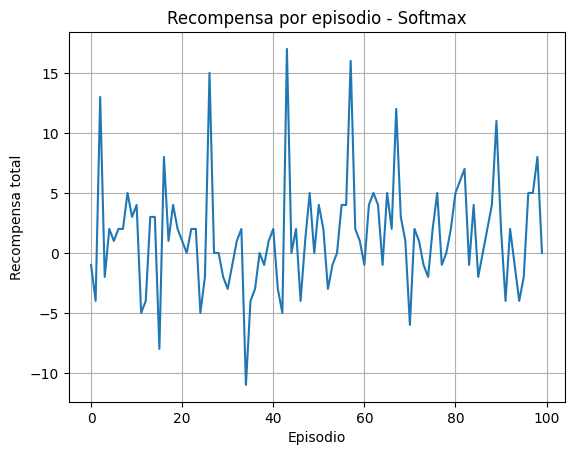

In [17]:
rewards_softmax, _ = train(softmax, episodes=100)
plt.plot(rewards_softmax)
plt.title("Recompensa por episodio - Softmax")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.grid(True)
plt.show()


## 4. Upper Confidence Bound (UCB)

UCB calcula un límite superior de confianza para cada acción combinando su valor Q y su nivel de incertidumbre.


In [18]:
def ucb(q_table, action_counts, state, t, epsilon):
    q_values = q_table[state]
    counts = action_counts[state] + 1e-5
    ucb_values = q_values + np.sqrt(2 * np.log(t + 1) / counts)
    return np.argmax(ucb_values)


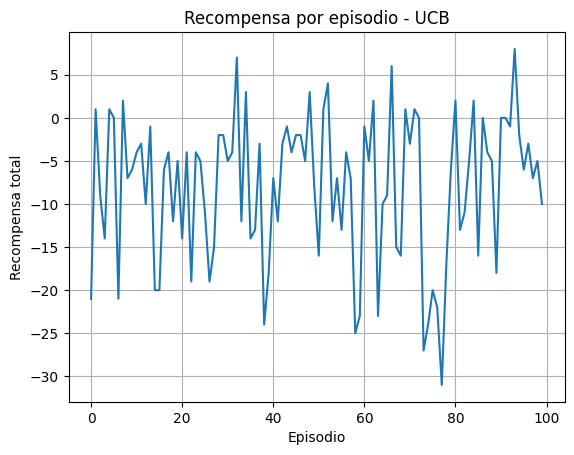

In [19]:
rewards_ucb, q_table_ucb = train(ucb, episodes=100)
plt.plot(rewards_ucb)
plt.title("Recompensa por episodio - UCB")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.grid(True)
plt.show()


## Comparación global de estrategias

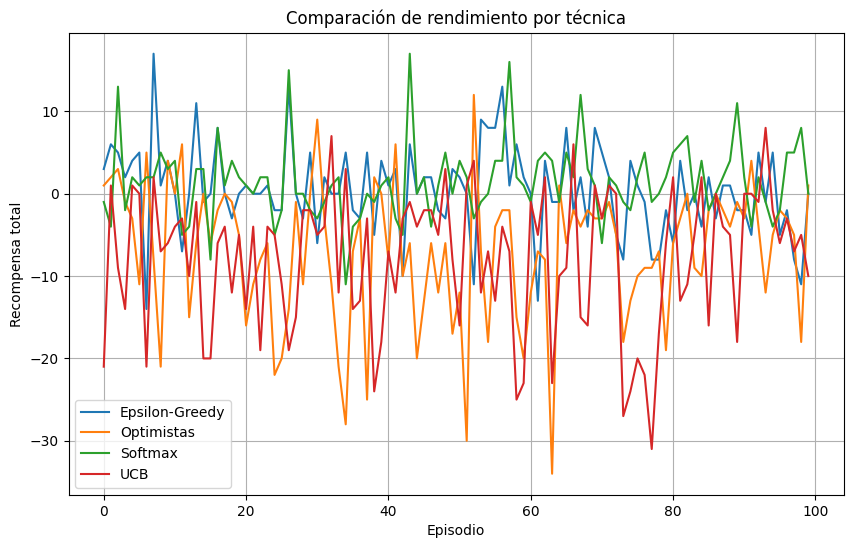

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_eps, label="Epsilon-Greedy")
plt.plot(rewards_opt, label="Optimistas")
plt.plot(rewards_softmax, label="Softmax")
plt.plot(rewards_ucb, label="UCB")
plt.title("Comparación de rendimiento por técnica")
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.legend()
plt.grid(True)
plt.show()


## Conclusión

Cada una de las estrategias de exploración-explotación presenta fortalezas distintas:
- **Epsilon-Greedy** es simple y efectiva con buen ajuste de ε.
- **Optimistas** explora fuertemente al inicio.
- **Softmax** ofrece una transición suave entre exploración y explotación.
- **UCB** balancea de manera inteligente la recompensa y la incertidumbre.

UCB suele ser más eficiente cuando se dispone de suficiente tiempo de entrenamiento y entornos estables.
